In [227]:
import torch
import torch.nn as nn 
from torchvision import  datasets, models, transforms
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader
import numpy as np 
import time
import matplotlib.pyplot as plt 
from PIL import Image
import os 
from collections import Counter
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve,  auc
from sklearn.preprocessing import label_binarize


In [211]:
print(torch.__version__)

2.4.1


In [192]:
transform = transforms.Compose([
    
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(10), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #* these  values i use for grayscale since the chest x rays is 
])

In [193]:
data_dir = './Datasets/LungXRays-grayscale'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)
print(f'training data: {len(train_dataset)}')
print(f'validation data: {len(val_dataset)}')
print(f'test data: {len(test_dataset)}')

training data: 4861
validation data: 1620
test data: 1625


In [195]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True); 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataiter = iter(train_loader)
imgs, labels = next(dataiter)
print(imgs.shape)
print(torch.min(imgs), torch.max(imgs))
print(f'images shapes: {imgs.shape}')

torch.Size([32, 3, 224, 224])
tensor(-2.1179) tensor(2.6400)
images shapes: torch.Size([32, 3, 224, 224])


In [196]:
#* resNet18 => since resnet50 requires high computation cost 
num_classes = len(train_dataset.classes)
restNet18_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
restNet18_model.fc = nn.Linear(restNet18_model.fc.in_features, num_classes)


In [ ]:
 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = restNet18_model.to(device) 
 
criterion = nn.CrossEntropyLoss();  
#optimizer = optim.Adam(model.parameters(), lr=0.0001 ) #* see which  learning rate is optimal
#optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epoch = 20

In [ ]:

def train_model(model, train_loader, criterion, optimizer, device):
    

        #* we sting the model into train mode
    model.train(); 
    
    learning_loss = 0.0; 
    correct = 0; 
    total = 0; 
    
    for inputs, labels in train_loader: 
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs); 
        loss = criterion(outputs, labels); 
        loss.backward();
        optimizer.step(); 
        learning_loss += loss.item(); 
        _, predict = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predict == labels).sum().item(); 
    
    learning_loss_result = learning_loss / total if total > 0 else 0
    train_acc = 100 * correct /total if total > 0 else 0
    return learning_loss_result, train_acc
                

In [ ]:

def validation(model, val_loader, criterion, device ): 
    model.eval(); 
    running_loss = 0.0; 
    total = 0; 
    correct = 0; 
    
    with torch.no_grad(): 
        for inputs, labels in val_loader: 
            inputs, labels = inputs.to(device), labels.to(device); 
            outputs = model(inputs); 
            loss = criterion(outputs, labels); 
            running_loss += loss.item(); 
            _,predict = torch.max(outputs, 1); 
            
            total  += labels.size(0); 
            correct  += (predict == labels).sum().item()
            
    result_running_loss = running_loss / total if total > 0 else 0 
    result_val_acc = 100* correct / total if total > 0 else 0; 
    return  result_running_loss, result_val_acc; 

In [ ]:
#* class for the early stopping 
class EarlyStopping:
    def __init__(self, patience =5, delta = 0, path='best.pt'):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.delta = delta
        self.path = path
    
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            
            #* here we keep track for if val decreases and save the best model
            print(f'Validation loss started decreasing from: {self.best_loss:.4f} to {val_loss:.4f} saves best model..')
            self.best_loss = val_loss 
            self.Save_best_model(model)
            self.counter = 0
        else: 
            self.counter += 1 
            print(f'Early stopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
    
    def Save_best_model(self, model): 
        torch.save(model.state_dict(), self.path)
            

In [ ]:
earlyStopping = EarlyStopping(patience=5,  path='best_resNet18.pth')
start_time = time.time()
train_losses, train_accs, val_losses, val_accs =[], [], [], []
for epoch in range(num_epoch):
    
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validation(model, val_loader, criterion, device)
    train_losses.append(train_loss); 
    train_accs.append(train_acc); 
    val_losses.append(val_loss)
    val_accs.append(val_acc); 

    print(f'Epoch {epoch+1}/{num_epoch}: Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    earlyStopping(val_loss, model)
    if earlyStopping.early_stop: 
        print('Note early stopping is triggered no need more training')
        break
end_time = time.time()
print(f'Training time for ResNet18: {end_time-start_time:.2f} seconds')

Epoch 1/20: Train Loss: 0.0145 Train Acc: 82.3287, Val Loss: 0.0057, Val Acc: 94.6914
Validation loss started decreasing from: inf to 0.0057 saves best model..
Epoch 2/20: Train Loss: 0.0053 Train Acc: 94.1987, Val Loss: 0.0045, Val Acc: 95.0617
Validation loss started decreasing from: 0.0057 to 0.0045 saves best model..
Epoch 3/20: Train Loss: 0.0037 Train Acc: 95.7828, Val Loss: 0.0039, Val Acc: 95.7407
Validation loss started decreasing from: 0.0045 to 0.0039 saves best model..
Epoch 4/20: Train Loss: 0.0035 Train Acc: 95.8650, Val Loss: 0.0036, Val Acc: 95.7407
Validation loss started decreasing from: 0.0039 to 0.0036 saves best model..
Epoch 5/20: Train Loss: 0.0027 Train Acc: 97.0171, Val Loss: 0.0032, Val Acc: 96.8519
Validation loss started decreasing from: 0.0036 to 0.0032 saves best model..
Epoch 6/20: Train Loss: 0.0025 Train Acc: 97.3051, Val Loss: 0.0033, Val Acc: 96.7284
Early stopping counter: 1 out of 5
Epoch 7/20: Train Loss: 0.0021 Train Acc: 97.9428, Val Loss: 0.0029

In [202]:
#* loading  the best model resNet18
restNet18_model.load_state_dict(torch.load('best_resNet18.pth', map_location=device, weights_only=True))
model = restNet18_model.to(device)


In [203]:
print(val_accs)

[94.69135802469135, 95.06172839506173, 95.74074074074075, 95.74074074074075, 96.85185185185185, 96.72839506172839, 96.60493827160494, 96.72839506172839, 97.28395061728395, 96.60493827160494, 97.46913580246914, 97.34567901234568, 97.34567901234568, 97.53086419753086, 97.71604938271605, 97.77777777777777, 97.65432098765432, 97.8395061728395, 97.53086419753086, 97.4074074074074]


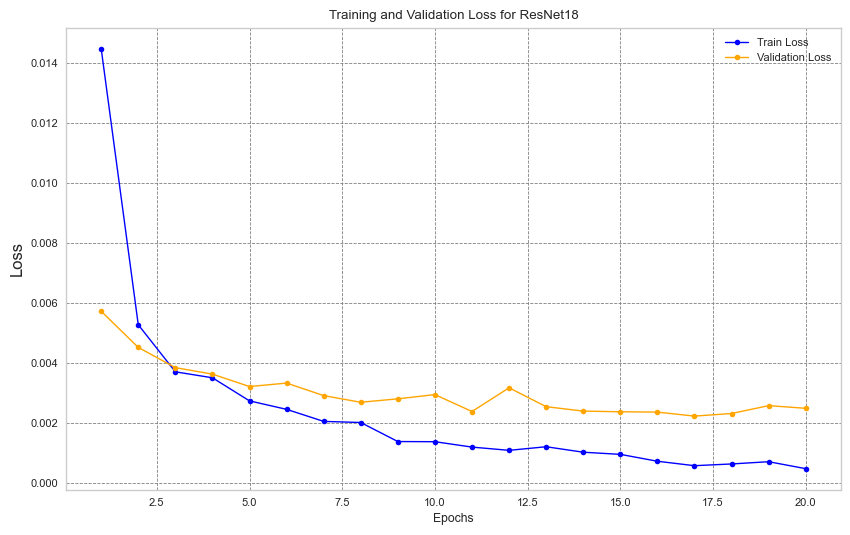

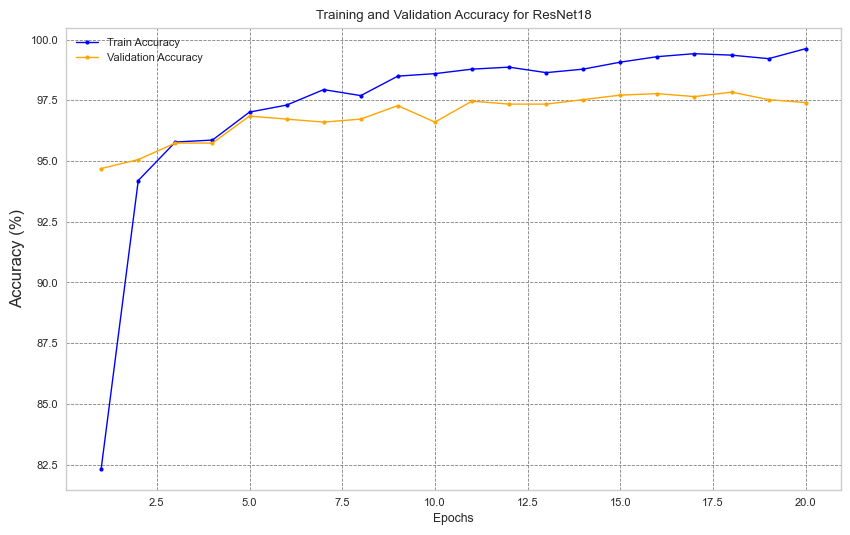

In [ ]:
def Plot_metrics(train_losses, val_losses, train_accs, val_accs):
    #* range for the plot 
   
    epoch =range(1, len(train_losses)+1)
    plt.figure(figsize=(10, 6))
    plt.plot(epoch, train_losses, label= 'Train Loss', color = 'blue',  marker='o', markersize=4, linestyle='-', linewidth=1)
    plt.plot(epoch, val_losses, label='Validation Loss', color='orange',  marker='o', markersize=4, linestyle='-', linewidth=1)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss for ResNet18')
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, color='gray')
    
    plt.show()
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(epoch, train_accs, label= 'Train Accuracy ', color = 'blue',  marker='o', markersize=3, linestyle='-', linewidth=1)
    plt.plot(epoch, val_accs, label='Validation Accuracy ', color='orange',  marker='o', markersize=3, linestyle='-', linewidth=1)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Training and Validation Accuracy for ResNet18')

    plt.grid(True, which='both', linestyle='--', linewidth=0.6, color='gray')
    plt.show()


Plot_metrics(train_losses, val_losses,  train_accs,  val_accs)

In [238]:
def evaluation(model, test_loader, criterion, device):
    test_loss = 0.0
    all_pred = []
    all_labels = []
    all_probs = []   
    correct = 0
    total = 0
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
       
            _, predicted = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            
            all_pred.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
  
    result_test_loss = test_loss / len(test_loader)
    result_test_acc = 100 * correct / total
    
     
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs) 
    num_classes = all_probs.shape[1]
    y_true = label_binarize(all_labels, classes=range(num_classes))
    auc = roc_auc_score(y_true, all_probs, multi_class='ovr', average='macro')
    
    
    return result_test_loss, result_test_acc, all_pred, all_labels, auc, all_probs

In [239]:
test_loss, test_acc, all_preds, all_labels, auc, all_probs= evaluation(model, test_loader, criterion, device)
print(f'Test Accuaracy: {test_acc:.2f}% AUC: {auc:.4f}')

Test Accuaracy: 97.85% AUC: 0.9992


Accuracy: 97.85

 classification Report
              precision    recall  f1-score   support

     COVID19     0.9877    0.9829    0.9853       409
      Normal     0.9604    0.9773    0.9688       397
   Pneumonia     0.9779    0.9637    0.9707       413
Tuberculosis     0.9877    0.9901    0.9889       406

    accuracy                         0.9785      1625
   macro avg     0.9784    0.9785    0.9784      1625
weighted avg     0.9785    0.9785    0.9785      1625



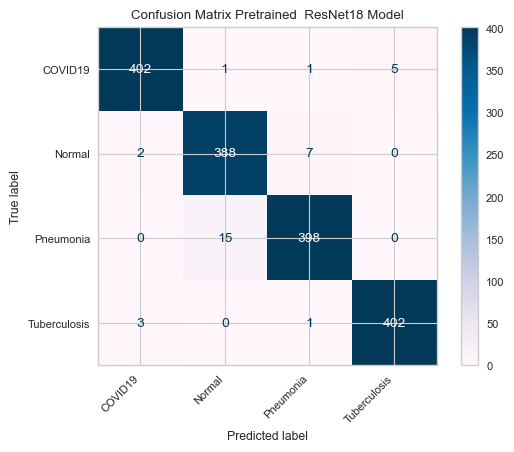

In [ ]:

accuracy = accuracy_score(all_preds, all_labels)
print(f"Accuracy: {100*accuracy:.2f}")
print('\n classification Report')
cls_report = classification_report(all_preds, all_labels, target_names=train_dataset.classes, digits=4)
print(cls_report)

cm = confusion_matrix(all_preds, all_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
display.plot(cmap='Blues' )


plt.xticks(rotation = 45, ha= 'right')
plt.title('Confusion Matrix Pretrained  ResNet18 Model')
plt.show()

In [ ]:

#* plotting auc curve for each classes 
def plot_roc_curve(all_labels, all_probs, num_classes, class_names):
    
    y_true = label_binarize(all_labels, classes=range(num_classes))
    all_probs = np.array(all_probs)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

 
    plt.figure(figsize=(4, 4))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


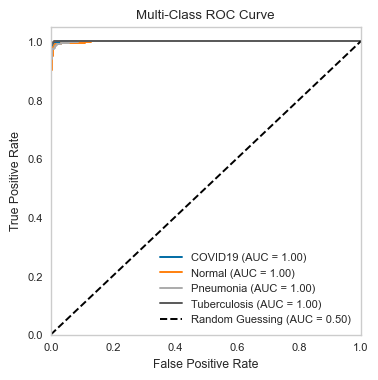

In [244]:
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes   
plot_roc_curve(all_labels, all_probs, num_classes, class_names)